# **Deep Convolutional Generative Adversarial Network (DC-GAN):**



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
tf.__version__


'2.9.2'

In [4]:
# To generate GIFs for illustration
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [50]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [51]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [52]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [53]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [54]:
# Generator

def make_generator_model():
    model = tf.keras.Sequential()
    # Fully connected layer: model.add(layers.Dense(#*#*#, use_bias=False, input_shape=(100,)))  
    # Batch norm
    # Activation function
    # Reshape
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    
    # Layer 2: Hint use layers.Conv2DTranspose with 5x5 kernels and appropriate stride
    model.add(layers.Conv2DTranspose(filters=128, kernel_size=5, strides=1, use_bias=False, padding="same"))

    assert model.output_shape == (None, 7, 7, 128) # Note: None is the batch size

    # Layer 3
    model.add(layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, use_bias=False, padding="same"))
    assert model.output_shape == (None, 14, 14, 64)

    #Layer4
    model.add(layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding="same", use_bias=False))
    
    assert model.output_shape == (None, 28, 28, 1)

    return model

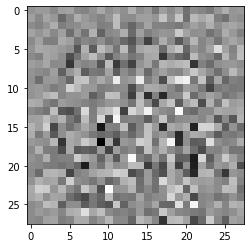

In [55]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [56]:
# Discriminator

def make_discriminator_model():
    model = tf.keras.Sequential()
    # Layer 1: use layers.Conv2D with 5x5 kernels and appropriate stride
    # Activation function
    # Dropout
    model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Layer 2: Conv2D
    # Activation function
    # Dropout
    model.add(layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Layer 3: Fully connected layer, output dimension must be 1
    model.add(layers.Flatten())
    model.add(layers.Dense(units=1))

    return model

In [57]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00240217]], shape=(1, 1), dtype=float32)


In [ ]:
# Define Loss and Optimizers

In [58]:
# This method returns a helper function to compute the binary cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [59]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [60]:
def generator_loss(fake_output):
    generator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return generator_loss

In [61]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #learning rate of 1e-4
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [62]:
# Saving Checkpoints

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [63]:
# Define Training Loop

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16 # For visualization

# We will reuse this noise_vector overtime (so it's easier)
noise_vector = tf.random.normal([num_examples_to_generate, noise_dim])

In [64]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise_vector = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generator output
      generated_images = generator(noise_vector, training=True)
      
      # Discriminator output
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      
      # Loss functions
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
  
    # Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [65]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             noise_vector)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           noise_vector)

In [66]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

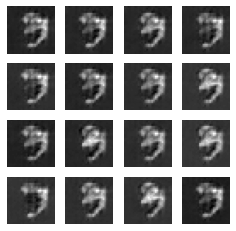

CPU times: user 2min 45s, sys: 25.4 s, total: 3min 11s
Wall time: 12min 24s


In [67]:
%%time
train(train_dataset, EPOCHS)